## Configurations

In [38]:
class CFG:
    text_file_path = "story.txt"
    # text_file_path = "corpus.txt"
    stopwords = []
    window_size = 1
    embed_size = 2
    n_epoch = 3000
    lr = 0.05
    batch_size = 32

## Important libraries

In [39]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import torch
import torch.optim as optim
import re
from helper import plot_embeddings
import torch.nn.functional as F

## Corpus

In [40]:
# Reading the file and splitting the sentences
with open(CFG.text_file_path, "r") as file:
    text = file.read()

# Splitting text by '.' or '\n'
corpus = [sentence.strip('\n') for sentence in re.split(r'[.]', text) if sentence.strip()] # r'[.\n]'

# Displaying the first few sentences to verify
print(corpus[:5])

['Countries are known for their capitals, and each capital represents unique aspects of its nation', ' France, known for the famous city of Paris, attracts tourists with its rich culture and history', ' Germany is home to Berlin, a capital known for its vibrant arts and culture scenes', ' Italy, famous for ancient history, has Rome as its capital, where visitors can see old ruins and rich architecture', ' Spain has its capital in Madrid, where art and music flourish']


## Preprocess the corpus

In [41]:
def preprocess(corpus, stopwords = CFG.stopwords):
    # Tokenize and remove stopwords
    tokenized = [[word for word  in sentence.lower().split() if word not in stopwords]
                 for sentence in corpus]
    return tokenized

tokenized_corpus = preprocess(corpus)
print(tokenized_corpus[:6])

[['countries', 'are', 'known', 'for', 'their', 'capitals,', 'and', 'each', 'capital', 'represents', 'unique', 'aspects', 'of', 'its', 'nation'], ['france,', 'known', 'for', 'the', 'famous', 'city', 'of', 'paris,', 'attracts', 'tourists', 'with', 'its', 'rich', 'culture', 'and', 'history'], ['germany', 'is', 'home', 'to', 'berlin,', 'a', 'capital', 'known', 'for', 'its', 'vibrant', 'arts', 'and', 'culture', 'scenes'], ['italy,', 'famous', 'for', 'ancient', 'history,', 'has', 'rome', 'as', 'its', 'capital,', 'where', 'visitors', 'can', 'see', 'old', 'ruins', 'and', 'rich', 'architecture'], ['spain', 'has', 'its', 'capital', 'in', 'madrid,', 'where', 'art', 'and', 'music', 'flourish'], ['japan’s', 'capital,', 'tokyo,', 'is', 'a', 'city', 'of', 'innovation', 'and', 'modernity', 'while', 'keeping', 'historical', 'traditions', 'alive']]


## Vocab

In [42]:
vocab = {word: idx for idx, word in enumerate(list(set([word for sentence in tokenized_corpus for word in sentence])))}
idx2word = {v: k for k, v in vocab.items()}
vocab_size = len(vocab)
vocab_size

220

## Create Dataset

In [43]:
def one_hot_encoding(idx, vocab_size = vocab_size):
    encod = torch.zeros(vocab_size)
    encod[idx] = 1
    return encod

one_hot_encoding(0)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [44]:
class Word2VecDataset(Dataset):
    def __init__(self, tokenized_corpus, vocab, window_size = CFG.window_size):
        self.pairs = []
        self.vocab = vocab
        self.window_size = window_size
        
        for sentence in tokenized_corpus:
            sentence_length = len(sentence)
            for idx, word in enumerate(sentence):
                target_word = self.vocab[word]
                context_indices = list(range(max(0, idx - window_size), min(sentence_length, idx + window_size + 1)))
                context_indices.remove(idx)  # Remove target word from context
                context_words = [self.vocab[sentence[context_idx]] for context_idx in context_indices]
                if len(context_words) > 0:
                    self.pairs.append((target_word, context_words))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        y, context_indices = self.pairs[index]
        y = torch.tensor(y, dtype = torch.long)
        
        # context_vectors = torch.cat(([one_hot_encoding(c_idx, vocab_size) for c_idx in context_indices]), dim = 0)
        # padding_needed = 2 * CFG.window_size * vocab_size - len(context_vectors)

        # padding_tensor = torch.zeros(padding_needed, dtype = context_vectors.dtype)
        # # Concatenate the original tensor with the padding tensor
        # x = torch.cat((context_vectors, padding_tensor))
        x = torch.sum(torch.stack([one_hot_encoding(c_idx, vocab_size) for c_idx in context_indices]), dim = 0)
        return x, y

# Create the dataset and dataloader
dataset = Word2VecDataset(tokenized_corpus, vocab)
dataloader = DataLoader(dataset, batch_size = CFG.batch_size, shuffle = True)
print(len(dataset))

394


## Define Model

In [45]:
class Word2Vec(nn.Module):
  def __init__(self, vocab_size, embed_size):
    super(Word2Vec, self).__init__()
    # self.input_dim =  2 * CFG.window_size * vocab_size
    self.input_dim = vocab_size
    self.hidden_layer = nn.Linear(self.input_dim, embed_size)
    self.output_layer = nn.Linear(embed_size, vocab_size)

  def forward(self, contexts):
    y = self.hidden_layer(contexts)
    y = self.output_layer(y)
    y = nn.Softmax(dim = -1)(y)
    return y
  
# Initialize the model, optimizer, and loss function  
model = Word2Vec(vocab_size, CFG.embed_size)
optimizer = optim.SGD(model.parameters(), lr = CFG.lr)
loss_fn = nn.CrossEntropyLoss()

## Train the model

In [46]:
for epoch in range(CFG.n_epoch):
    total_loss = 0
    for x, y in dataloader:
        # Forward pass: predict context word embedding for each one-hot target word
        yhat = model(x)  # Get target embedding

        # Calculate loss based on predicted and actual context indices
        optimizer.zero_grad()

        loss = loss_fn(yhat, y)  # CrossEntropyLoss expects class indices for target
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # Average the loss over all batches for this epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{CFG.n_epoch}], Average Loss: {avg_loss:.6f}")

Epoch [1/3000], Average Loss: 5.393632
Epoch [2/3000], Average Loss: 5.393622
Epoch [3/3000], Average Loss: 5.393634
Epoch [4/3000], Average Loss: 5.393625
Epoch [5/3000], Average Loss: 5.393650
Epoch [6/3000], Average Loss: 5.393662
Epoch [7/3000], Average Loss: 5.393623
Epoch [8/3000], Average Loss: 5.393662
Epoch [9/3000], Average Loss: 5.393689
Epoch [10/3000], Average Loss: 5.393643
Epoch [11/3000], Average Loss: 5.393652
Epoch [12/3000], Average Loss: 5.393648
Epoch [13/3000], Average Loss: 5.393625
Epoch [14/3000], Average Loss: 5.393644
Epoch [15/3000], Average Loss: 5.393660
Epoch [16/3000], Average Loss: 5.393608
Epoch [17/3000], Average Loss: 5.393600
Epoch [18/3000], Average Loss: 5.393611
Epoch [19/3000], Average Loss: 5.393662
Epoch [20/3000], Average Loss: 5.393625
Epoch [21/3000], Average Loss: 5.393658
Epoch [22/3000], Average Loss: 5.393621
Epoch [23/3000], Average Loss: 5.393646
Epoch [24/3000], Average Loss: 5.393662
Epoch [25/3000], Average Loss: 5.393652
Epoch [26

In [ ]:
output_layer_weights = list(model.output_layer.parameters())
raw_embeddings = output_layer_weights[0].detach()
embeddings = {idx2word[idx]: embed for idx, embed in enumerate(raw_embeddings)}
embeddings

{'language,': tensor([-0.1195, -0.0697, -0.0304,  0.0010,  0.0912,  0.0441, -0.0671,  0.0986,
          0.0178,  0.0147, -0.0997, -0.0382,  0.1153,  0.0613,  0.0492,  0.0591,
         -0.1231,  0.0628,  0.1073,  0.0670, -0.0028, -0.0058, -0.0798,  0.0897,
         -0.0701, -0.0075, -0.0983,  0.0887,  0.0084, -0.0355, -0.0720, -0.0819,
          0.0538,  0.0979, -0.0860, -0.0721, -0.0278, -0.1101,  0.0540, -0.0019,
          0.1164, -0.0033, -0.0900,  0.1094,  0.0135, -0.0730,  0.1196,  0.0611,
         -0.0447,  0.0838, -0.0722,  0.0259,  0.0319,  0.1054, -0.0830, -0.0896,
          0.1217, -0.0761,  0.0766,  0.0387,  0.1218, -0.0831,  0.1035, -0.0250]),
 'countries': tensor([-0.0685,  0.1034,  0.1126,  0.0505,  0.0398, -0.1182, -0.0414,  0.1048,
          0.0065, -0.0793,  0.1225, -0.0772,  0.0218, -0.0684,  0.0116, -0.0170,
          0.0055, -0.1019,  0.0059,  0.0417, -0.0879,  0.0152,  0.0113, -0.0832,
          0.1245, -0.0018,  0.1058, -0.0700, -0.0321, -0.0289, -0.1036, -0.1075,


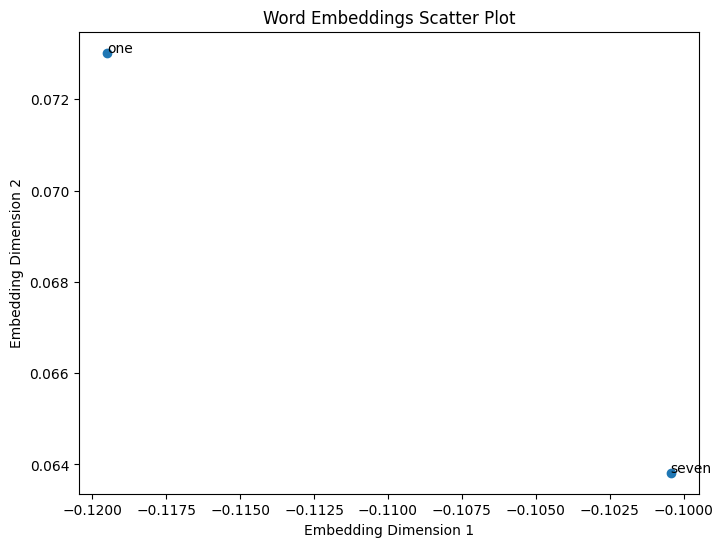

In [ ]:
words = ['holmes', 'man', 'woman', 'friend', 'Atkinson', 'Baker', 'cigarette', 'clues', 'german-speaking', 'watson', 'address','european', 'coat'
         'two', 'double', 'high', 'little', "men's", 'white', 'seven', 'he', 'she', 'beauties', 'seventeen', 'one', 'too', 'blue', 'window', 'door']
# words = [word.lower() for word in words]
words = list(vocab.keys())
plot_embeddings(embeddings, words = words)